<center>
    <img src="https://raw.githubusercontent.com/dvgodoy/PyTorch101_ODSC_Europe2020/master/images/linear_dogs.jpg" width="800"> 
</center>  

# Yet another math for DS course: домашнее задание 6

**ФИО:**
Богуш Иван Сергеевич

## Задача №1: 50 оттенков градиентного спуска (10 баллов)

В этом задании вам предстоит реализовать линейный классификатор и натренировать его, используя различные модификации градинетного спуска. 

In [74]:
import pandas as pd 

In [251]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd 

Для наших целей будем использовать искуственно сгенерированные данные.

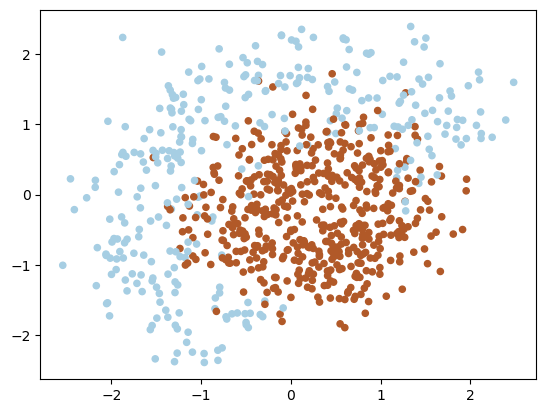

In [252]:
from sklearn import datasets, preprocessing

# keep random_state=42 for deterministic results
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4, random_state=42)
ind = np.logical_or(y == 1, X[:, 1] > X[:, 0] - 0.5)
X = X[ind, :]
m = np.array([[1, 1], [-2, 1]])
X = preprocessing.scale(X)
y = y[ind]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)
plt.show()

__[1 балл]__ Как вы можете заметить, данные не являются линейно разделимыми. Нам придётся добавить в обучающую выборку новые фичи либо использовать нелинейные модели. Предположим, что разделяющая поверхность имеет вид окружности. Добавьте в матрицу признаков дополнительные колонки $x_1^2$, $x_2^2$ и $x_1 \cdot x_2$.

In [254]:
def expand(X):
    """
    Добавляет квадратичные фичи. 
    Для каждой строки матрицы находит строку 
    [feature0, feature1, feature0^2, feature1^2, feature0*feature1, 1]
    
    :param X: матрица фичей, shape [n_samples,2]
    :returns: расширенная матрица фичей, shape [n_samples,6]
    """
    X = np.c_[X, X[:,0] * X[:,0]] 
    X = np.c_[X, X[:,1] * X[:,1]]
    X = np.c_[X, X[:,0] * X[:,1]]
    X = np.c_[X, np.ones(X.shape[0])]


    
    return X 

__[1 балл]__ Для классификации будем использовать логистическую регрессию. 

$$ a(x; w) = \langle w, x \rangle $$
$$ P( y=1 \; \big| \; x, \, w) = \dfrac{1}{1 + \exp(- \langle w, x \rangle)} = \sigma(\langle w, x \rangle)$$


In [255]:
def probability(X, w):
    """
    Принимает на вход матрицу фичей и вектор весов
    Возвращает предсказание вероятность того, что y = 1 при фиксированных x, P(y=1|x)
     
    :param X: расширенная матрица фичей [n_samples,6] (expanded)
    :param w: вектор весов [6]
    :returns: вектор вероятностей
    """
    sigmoid = 1/(1 + np.exp(- X @ w))
    return sigmoid

__[1 балл]__ Для логистической регрессии оптимальный параметр находится минимизацией кросс-энтропии: 

$$ L(w) =  - {1 \over \ell} \sum_{i=1}^\ell \left[ {y_i \cdot log P(y_i = 1 \, | \, x_i,w) + (1-y_i) \cdot log (1-P(y_i = 1 \, | \, x_i,w))}\right] $$



In [256]:
def compute_loss(X, y, w):
    """
    Принимает на вход матрицу весов, вектор ответов и вектор весов.
    Выдаёт на выход значение функции потерь, расчитанное по формуле выше.
    """
    l = X.shape[0]

    L = sum(y*np.log(probability(X, w)) + (1-y)*np.log(1-probability(X,w)))

    return -1 * L/l
    

__[2 балла]__ Мы будем обучать модель методом градиентного спуска. Для этого нам придётся вычислить градиент функции потерь, представленной выше. Возьмите листочек, ручку и в бой! 

$$ \nabla_w L = 1/l * X^T * (p - y) $$

In [257]:
def compute_grad(X, y, w):
    """
    Нахоит значение градиента.
    """

    l = X.shape[0]

    p = probability(X, w)

    return 1/l * X.T @ (p-y)

Функция ниже предназначена для визуализации процесса обучения. 

In [258]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

def visualize(X, y, w, history):
    """С помощью магии matplolib выдаёт красоты результатов классификации"""
    Z = probability(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.subplot(1, 2, 2)
    plt.plot(history)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

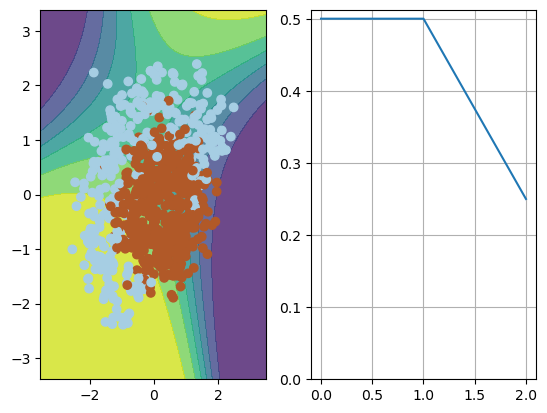

In [259]:
# убедитесь, что у вас она работает, запустив код ниже 
# (он отработает если вы верно реализовали expend и probability)
dummy_weights = np.linspace(-1, 1, 6)
visualize(X, y, dummy_weights, [0.5, 0.5, 0.25])

Пришло время обучить нашу модель. Для этого вам придётся дописать кусочки функций ниже. Обязательно попробуйте поменять гиперпараметры (размер батча и скорость обучения) и посмотреть как будет изменяться анимация. 

#### __[2 балла]__ Mini-batch SGD

Берём несколько рандомных наблюдений и ищем градиент по ним! 

$$ w_t = w_{t-1} - \eta \dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$

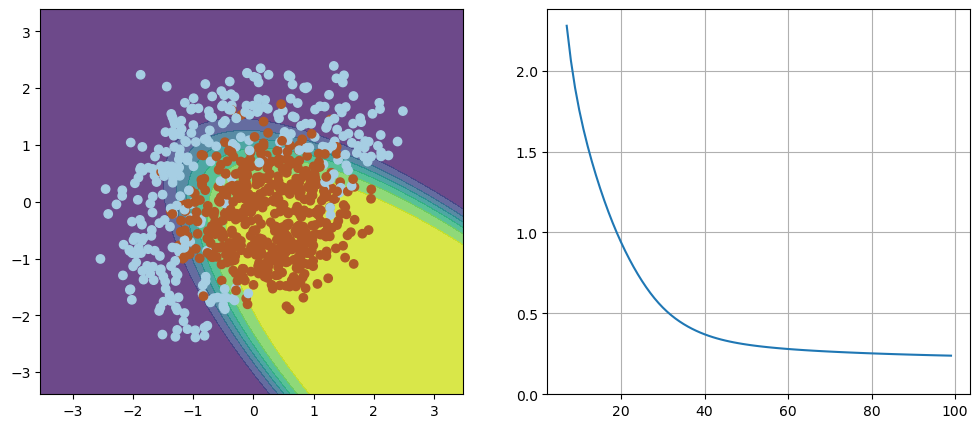

np.float64(0.23870076805290938)

In [260]:
# Обычный градиентный спуск 
np.random.seed(42)
w = np.array([5, 2, 6, 2, 0, 1])

eta = 0.6
alpha = 0.9 
nu = np.zeros_like(w)


n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

X_train = expand(X)
y_true = y 



for i in range(n_iter):

    y_pred = probability(X_train, w)
    loss[i] = compute_loss(X_train, y_true, w)

    grad = compute_grad(X_train, y_true, w) 

    w_new = w - eta *grad  

    w = w_new 


visualize(X_train, y, w, loss)
loss[-1]

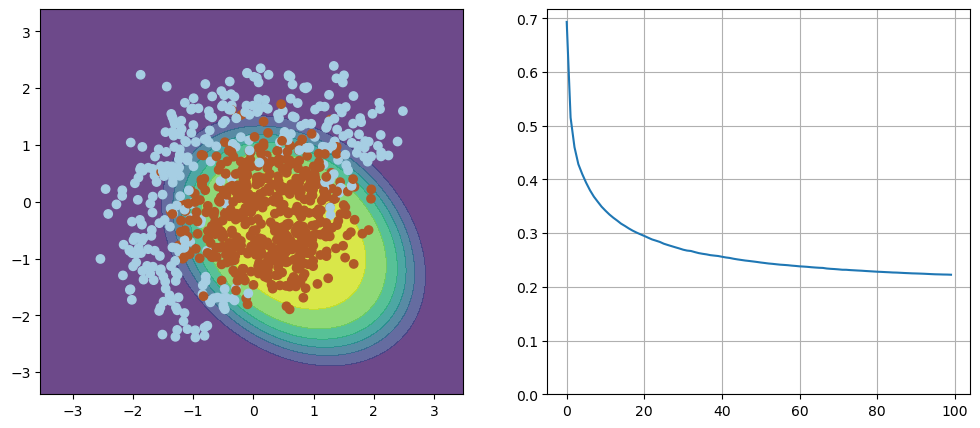

np.float64(0.22263675080532272)

In [262]:
# Mini batch SGD
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.6
alpha = 0.9 
nu = np.zeros_like(w)
batch_size =  242


n_iter = 100

loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))


X_train = expand(X)
y_true = y 

idx = np.random.choice(X.shape[0], batch_size, replace=False)
X_batch = X_train[idx]
y_batch = y_true[idx]

for i in range(n_iter):

    idx = np.random.choice(X_train.shape[0], size=batch_size, replace=False)
    X_batch = X_train[idx]
    y_batch = y_true[idx]


    y_pred = probability(X_batch, w)
    loss[i] = compute_loss(X_train, y_true, w)

    grad = compute_grad(X_batch, y_batch, w) 

    w_new = w -  eta *grad  

    w = w_new 


visualize(X_train, y, w, loss)
loss[-1]

#### __[1 балл]__ Momentum SGD

Momentum это метод, который помогает стохастическому градиентному спуску сохранять направление движения. Это осуществляется за счёт добавления в выражение дополнительного слагаемого: накопленного за предыдущие шаги градиента с весом $\alpha$. 
<br>
<br>

$$ \nu_t = \alpha \nu_{t-1} + \eta\dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$
$$ w_t = w_{t-1} - \nu_t$$


<Figure size 640x480 with 0 Axes>

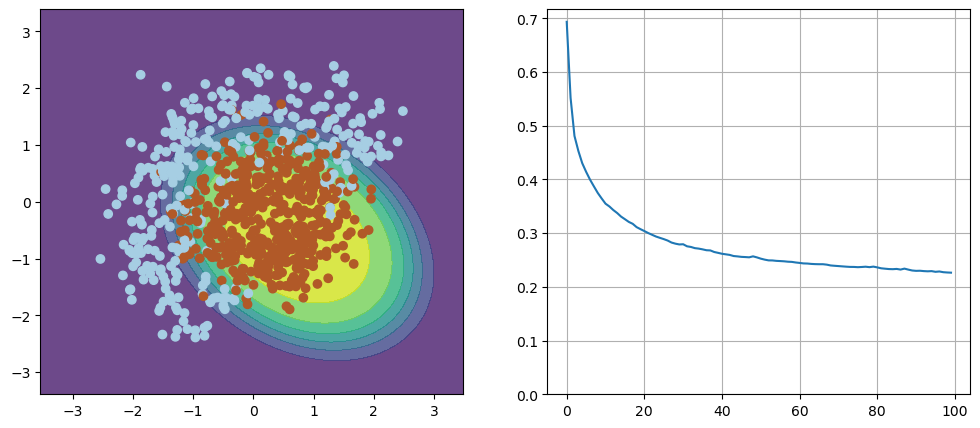

np.float64(0.22640247375093192)

In [412]:
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.5
alpha = 0.9 
nu = np.zeros_like(w)

n_iter = 100
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

X_train = expand(X)
y_true = y 
batch_size = 42

for i in range(n_iter):
    
    idx = np.random.choice(X_train.shape[0], size=batch_size)
    X_batch = X_train[idx]
    y_batch = y_true[idx]

    y_pred = probability(X_batch, w)
    loss[i] = compute_loss(X_train, y_true, w)
    grad = compute_grad(X_batch, y_batch, w)

    nu_new = alpha*nu + eta*grad
    w_new = w - nu_new
    w = w_new





visualize(X_train, y, w, loss)
plt.clf()
loss[-1]

#### __[1 балл]__ RMSprop

В этом блоке реализуем RMSprop. Эта вариация градиентного спуска позволяет изменять скорость обучения индивидуально для каждого параметра. 

$$ G_t^j = \alpha G_{t-1}^j + (1 - \alpha) g_{tj}^2 $$
$$ w_t^j = w_{t-1}^j - \dfrac{\eta}{\sqrt{G_t^j + \varepsilon}} g_{tj} $$

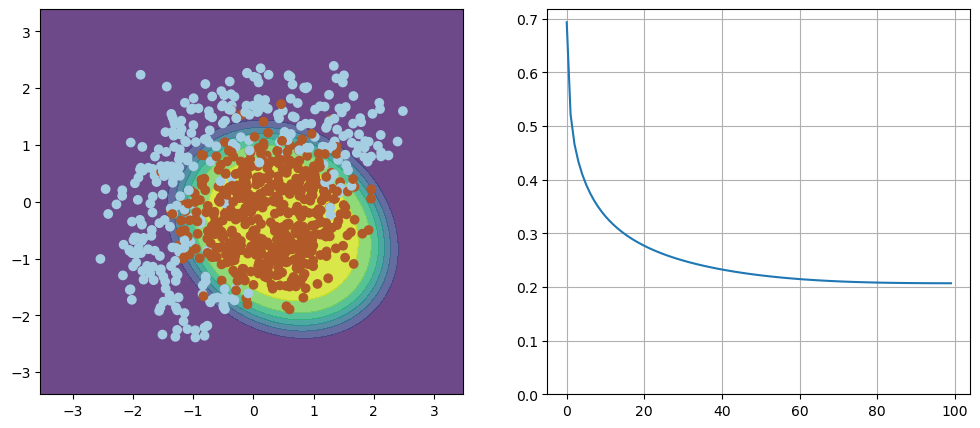

np.float64(0.2069534753756183)

In [406]:
np.random.seed(42)

w = np.array([0, 0, 0, 0, 0, 1.])

eta = 0.05
alpha = 0.9 
g2 = np.zeros_like(w)
eps = 1e-8
G = np.zeros_like(w)
n_iter = 100
loss = np.zeros(n_iter)

X_train = expand(X)
y_true = y


plt.figure(figsize=(12,5))


for i in range(n_iter):

    loss[i] = compute_loss(X_train, y_true, w)

    grad = compute_grad(X_train, y_true, w)

    
    G_new_i = alpha * G + (1-alpha) * grad**2
    w_new_i = w - eta/pow((G_new_i + eps),1/2) * grad
        
    G = G_new_i
    w = w_new_i
    


visualize(X_train, y, w, loss)
plt.clf()
loss[-1]

__[1 балл]__ Реализуйте Adam

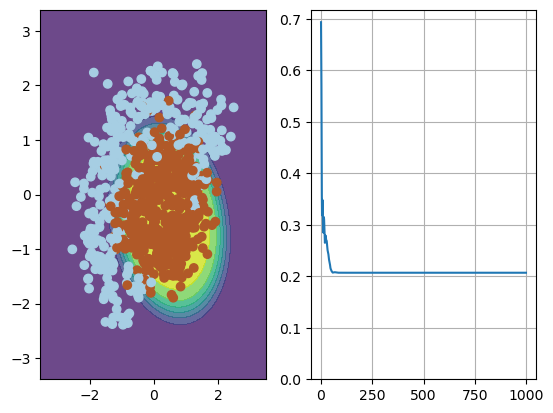

np.float64(0.20689525131424413)

In [281]:
np.random.seed(42)

w = np.array([0, 0, 0, 0, 0, 1.])

m = np.zeros_like(w)
v = np.zeros_like(w)
beta1 = 0.9
beta2 = 0.999
g2 = np.zeros_like(w)
eps = 1e-8
alpha = 0.9

n_iter = 1000
loss = np.zeros(n_iter)

X_train = expand(X)
y_true = y

for i in range(n_iter):

    g = compute_grad(X_train, y, w)
    loss[i] = compute_loss(X_train, y_true, w)

    m = beta1*m + (1-beta1)*g
    v = beta2*v + (1-beta2)*(g**2)

    m_hat = m / (1 - beta1**t)
    v_hat = v / (1 - beta2**t)

    w = w - alpha * m_hat / (np.sqrt(v_hat) + eps)



visualize(X_train, y, w, loss)
plt.clf()
loss[-1]

In [ ]:
# Лучший лосс среди всех видов градиентных спусков показал Adam. За 100 итереций наименьший лосс

__[бонусные 2]__ Выясните что такое метод Ньютона (метод второго порядка) и реализуйте его.

######## Гессиан для кросс энтропийной функции потерь 
$$ H = X^T*S*X, S - диагональная   матрица

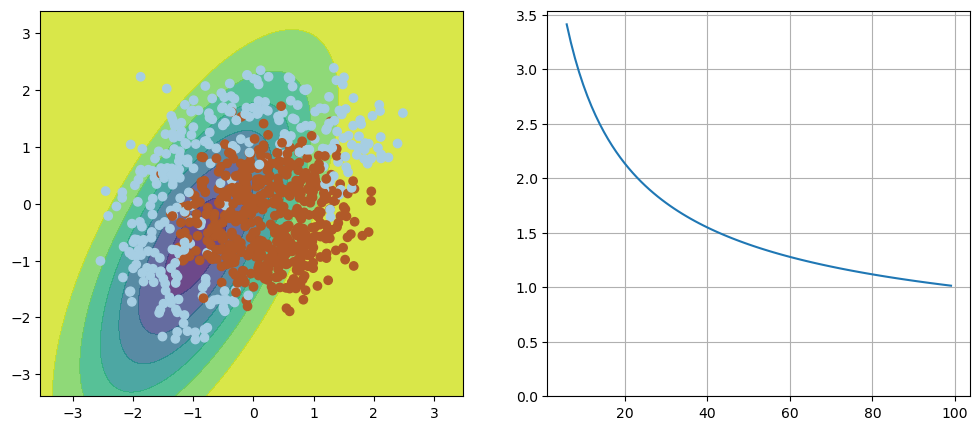

np.float64(1.0151464646549768)

In [381]:
# 
np.random.seed(42)
w = np.array([5, 2, 6, 2, 0, 1])

S = np.zeros_like(X_train)



n_iter = 100
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

X_train = expand(X)
y_true = y 



for i in range(n_iter):

    p = probability(X_train, w)
    loss[i] = compute_loss(X_train, y_true, w)
 
    S = np.diag(p * (1 - p))         
    H = X_train.T @ S @ X_train 
    H_inv = np.linalg.inv(H)

    w_new = w - H_inv @ compute_grad(X_train, y_true, w) 

    w = w_new 



visualize(X_train, y, w, loss)
plt.clf()
loss[-1]

__[бонусные 2]__ Выясните, что такое weight decay и реализуйте его для базовой версии SGD. Правда ли, что эта модернизация улучшает обучение?
Ответ:  С одинаковыми параметрами, SGD c weight decay незначительно проигрывает обычному SGD. В данном случае не улучшает. 

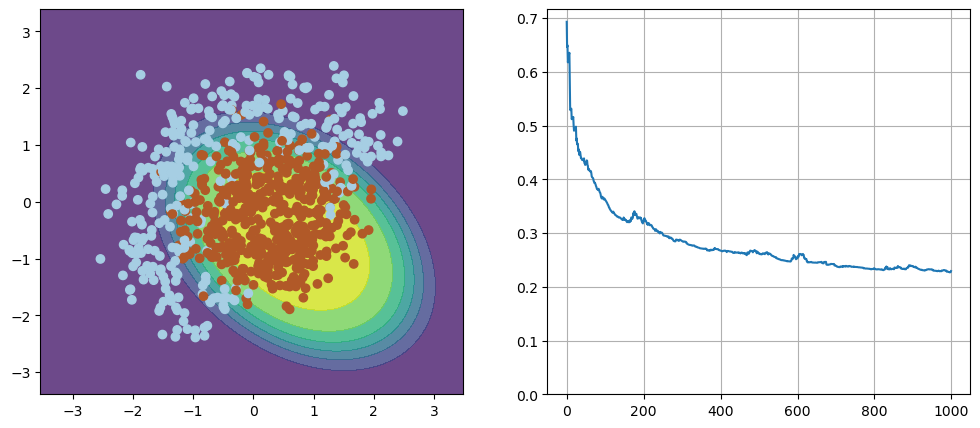

(np.float64(0.22931220553067308),
 array([ 0.98104537, -1.10989254, -1.14414705, -1.20791762, -0.8285696 ,
         3.0484324 ]))

In [405]:
# SGD c weight decay
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.05


batch_size =  1
weight_decay = 0.001

n_iter = 1000

loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))


X_train = expand(X)
y_true = y 

idx = np.random.choice(X.shape[0], batch_size, replace=False)
X_batch = X_train[idx]
y_batch = y_true[idx]

for i in range(n_iter):

    idx = np.random.choice(X_train.shape[0], size=batch_size, replace=False)
    X_batch = X_train[idx]
    y_batch = y_true[idx]


    loss[i] = compute_loss(X_train, y_true, w)

    grad = compute_grad(X_batch, y_batch, w) 

    w_new = (1 - eta * weight_decay) * w - eta * grad

    w = w_new 


visualize(X_train, y, w, loss)
loss[-1], w

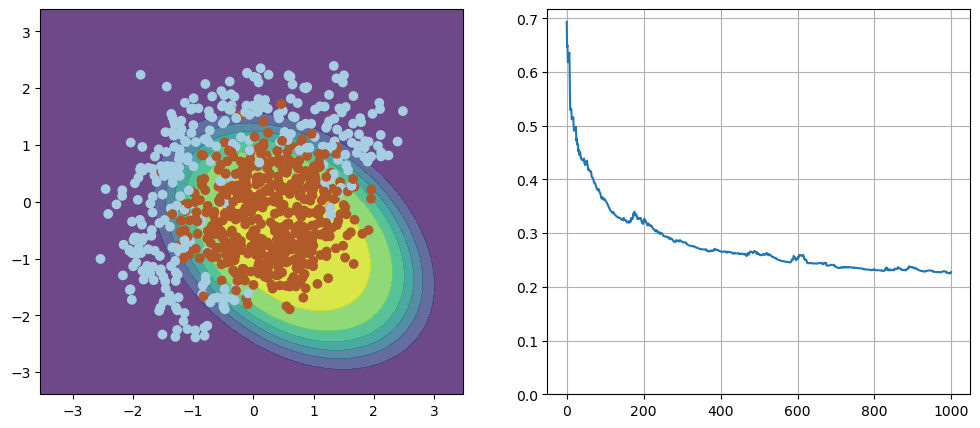

np.float64(0.22725837574122315)

In [404]:
# SGD без weight decay
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.05


batch_size =  1
weight_decay = 0.001

n_iter = 1000

loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))


X_train = expand(X)
y_true = y 

idx = np.random.choice(X.shape[0], batch_size, replace=False)
X_batch = X_train[idx]
y_batch = y_true[idx]

for i in range(n_iter):

    idx = np.random.choice(X_train.shape[0], size=batch_size, replace=False)
    X_batch = X_train[idx]
    y_batch = y_true[idx]


    loss[i] = compute_loss(X_train, y_true, w)

    grad = compute_grad(X_batch, y_batch, w) 

    w_new =  w - eta * grad

    w = w_new 


visualize(X_train, y, w, loss)
loss[-1]